# Phenogenetic architectures

## Overview

Here's where things start to get interesting. The ability to easily construct and modify phenogenetic architectures with arbitrary complexity was the core motivating feature underlying the development of `xftsim`. In what follows, we introduce the `ArchitectureComponent` and `Architecture` classes that make this possible.


:::{warning}

We highly suggest you be familiar with the `xftsim` indexers and data structures introduce [here](./indexing.ipynb) and [here](./struct.ipynb), respectively.

:::

## ArchitectureComponent objects 

An `Architecture` object largely consists of an iterable collection of `ArchitectureComponents`. These component objects take haplotype and phenotype data as inputs and modify phenotypes by reference. For example, the widely used additive genetic architecture

$$y=X\beta + e,$$
$$e \sim N(0, \sigma^2_e),$$
$$\beta \stackrel{iid}{\sim}N_m(0,\sigma^2_\beta),$$

is represented in `xftsim` as a collection of three components: the additive genetic component $X\beta$, the additive noise component $e$, and the sum transformation $y = X\beta + e$.


In [38]:
import xftsim as xft
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 240 ## better looking plots

demo = xft.sim.DemoSimulation("BGRM")
demo

<DemoSimulation>
Bivariate GCTA with balanced random mating demo

n = 2000; m = 400
Two phenotypes, height and bone mineral denisty (BMD)
assuming bivariate GCTA infinitessimal archtecture
with h2 values set to 0.5 and 0.4 for height and BMD
respectively and a genetic effect correlation of 0.0.

This architecture consists of three components:

In [39]:
len(demo.architecture.components)

3

The genetic component uses haplotype information (but not phenotype information) as inputs and generates the `additiveGenetic` phenotype component as its output:

In [40]:
demo.architecture.components[0]

<class 'xftsim.arch.AdditiveGeneticComponent'>

## INPUTS:
 - haplotypes: True
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.additiveGenetic.proband         height  additiveGenetic   
BMD.additiveGenetic.proband               BMD  additiveGenetic   

                                vorigin_relative     comp_type  
component                                                       
height.additiveGenetic.proband                -1  intermediate  
BMD.additiveGenetic.proband                   -1  intermediate  

The noise component, on the other hand, doesn't use haplotype information or phenotype information as inputs and generates the `additiveNoise` phenotype component as its output:

In [41]:
demo.architecture.components[1]

<class 'xftsim.arch.AdditiveNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                             phenotype_name component_name  vorigin_relative  \
component                                                                      
height.additiveNoise.proband         height  additiveNoise                -1   
BMD.additiveNoise.proband               BMD  additiveNoise                -1   

                                 comp_type  
component                                   
height.additiveNoise.proband  intermediate  
BMD.additiveNoise.proband     intermediate  

Finally, the sum component ignores haplotype data but uses both the `additiveGenetic` and `additiveNoise` components to compute the `phenotype` component:

In [42]:
demo.architecture.components[2]

<class 'xftsim.arch.SumAllTransformation'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<ComponentIndex>
  2 components of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.additiveGenetic.proband         height  additiveGenetic   
height.additiveNoise.proband           height    additiveNoise   
BMD.additiveGenetic.proband               BMD  additiveGenetic   
BMD.additiveNoise.proband                 BMD    additiveNoise   

                                vorigin_relative     comp_type  
component                                                       
height.additiveGenetic.proband                -1  intermediate  
height.additiveNoise.proband                  -1  intermediate  
BMD.additiveGenetic.proband                   -1  intermediate  
BMD.additiveNoise.proband                     -1  intermediate  

## OUTPUTS:
 - phenotype components:
<Com

## Dependency graphs

All `ArchitectureComponent` and `Architecture` objects include a `draw_dependency_graph()` method for visualizing the dependence between components. This can be helpful for making sure your model is correctly specified. For example, the `SumAllTransformation` above has the following dependency graph:

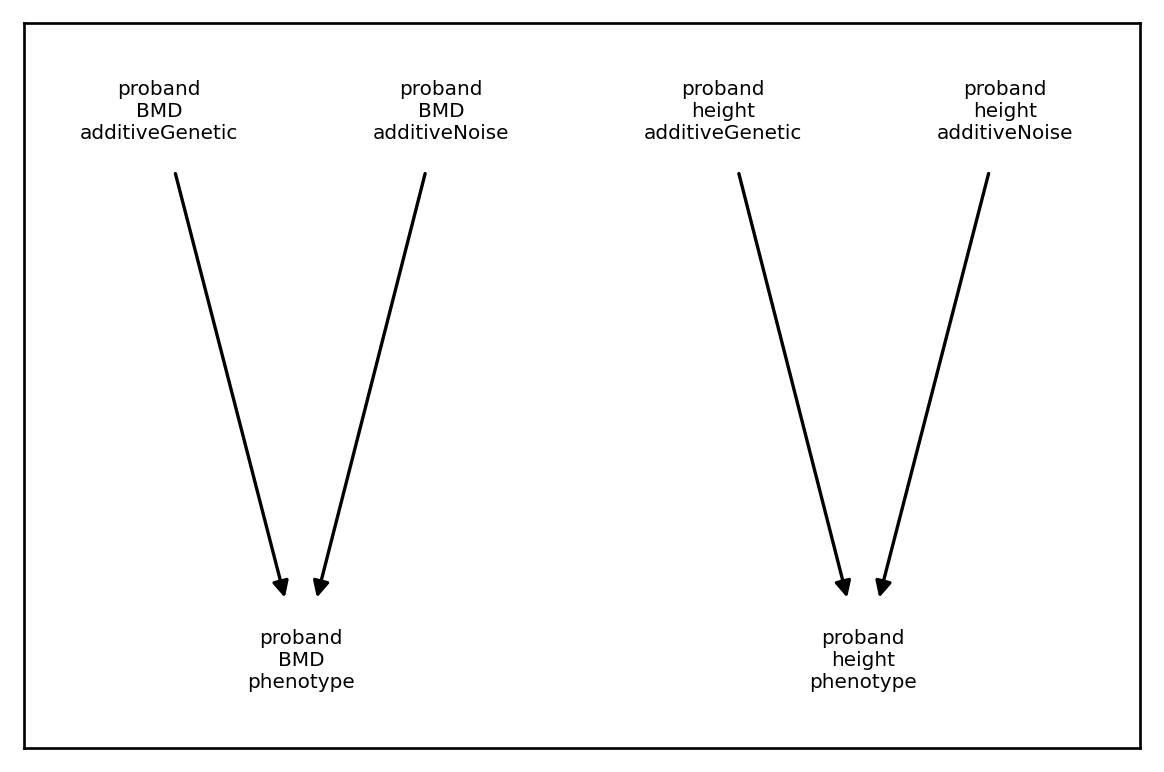

In [43]:
demo.architecture.components[2].draw_dependency_graph()

The `Architecture` object, which includes all three components has the following dependency graph:

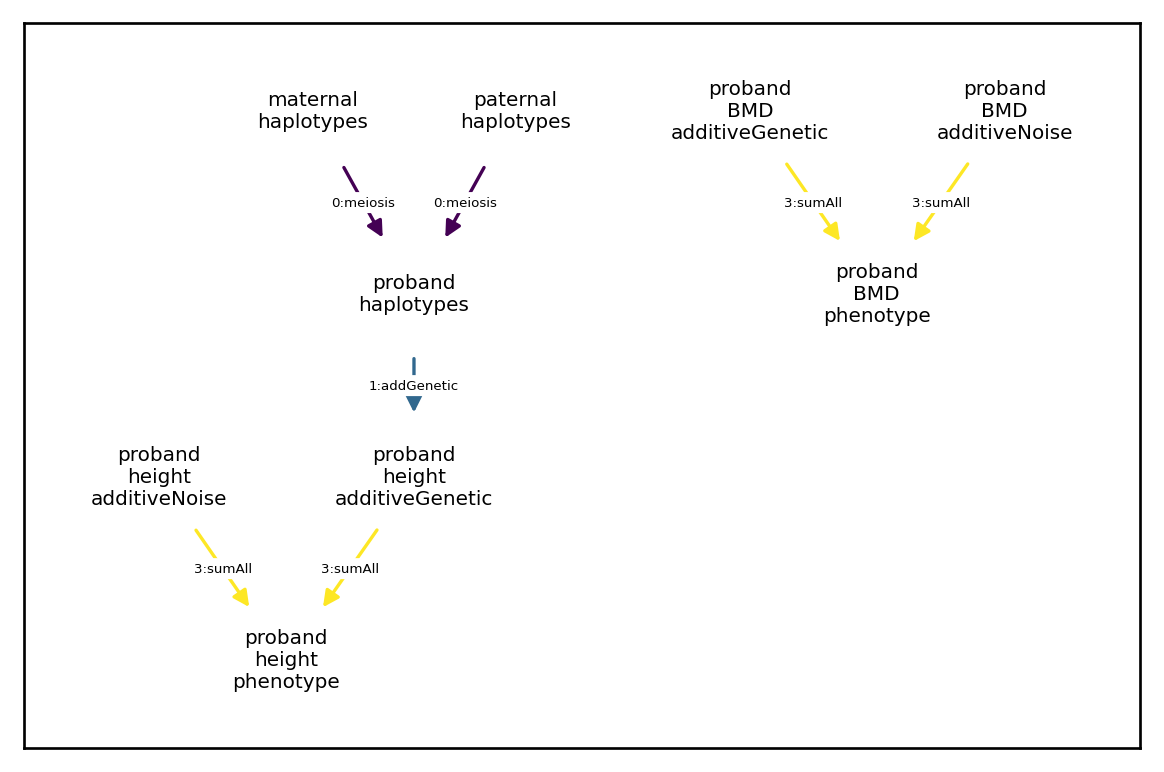

In [44]:
demo.architecture.draw_dependency_graph()

We will go through some commonly used `ArchitectureComponent`s (including the above) in what follows.

## Genetic components

To specify an 'arch.AdditiveGeneticComponent', we need to first create an `effect.AdditiveEffects` object. Additive effects relating $m$ diploid variants to $k$ phenotypic components are comprised of an $m\times k$ matrix of effects, an index of the $m$ variants (can be `xft.index.HaploidVariantIndex` or `xft.index.DiploidVariantIndex`), and an index of the $k$ components in the form of an `xft.index.ComponentIndex`. 

For example, we can create effects under the additive model specified above as follows:

In [45]:
import numpy as np

beta = np.random.randn(demo.haplotypes.xft.m, 1) * np.sqrt(.5)
vindex = demo.haplotypes.xft.get_variant_indexer()
cindex = xft.index.ComponentIndex.from_product('height', 'additiveGenetic')

effects = xft.effect.AdditiveEffects(beta=beta, 
                                     variant_indexer=vindex,
                                     component_indexer=cindex)

Alternatively, we could construct additive components for two phenotypes, height and bone mineral density (BMD), with genetic variances 0.5 and 0.4, respectively, and genetic effect correlation 0.25 as follows: 

In [46]:
m = demo.haplotypes.xft.m
vcov = np.array([[.5, .25*np.sqrt(.5*.4)],
                 [.25*np.sqrt(.5*.4), .4]])


beta = np.random.multivariate_normal(mean = np.zeros(2),
                                     cov = vcov, size = m)
vindex = demo.haplotypes.xft.get_variant_indexer()
cindex = xft.index.ComponentIndex.from_product(('height','BMD'), 'additiveGenetic')

effects = xft.effect.AdditiveEffects(beta=beta, 
                                     variant_indexer=vindex,
                                     component_indexer=cindex)

We can confirm that these effects behave as expected if desired:

In [47]:
correlation_matrix = np.corrcoef(demo.haplotypes.data @ effects.beta_unscaled_unstandardized_haploid, rowvar=-False)
covariance_matrix = np.cov(demo.haplotypes.data @ effects.beta_unscaled_unstandardized_haploid, rowvar=-False)

correlation_matrix, covariance_matrix


(array([[1.        , 0.19822503],
        [0.19822503, 1.        ]]),
 array([[0.59484534, 0.09823604],
        [0.09823604, 0.41287699]]))

We then pass the `AdditiveEffects` object to the `AdditiveGeneticComponent` constructor to generate the corresponding archetecture component:

<class 'xftsim.arch.AdditiveGeneticComponent'>

## INPUTS:
 - haplotypes: True
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.additiveGenetic.proband         height  additiveGenetic   
BMD.additiveGenetic.proband               BMD  additiveGenetic   

                                vorigin_relative     comp_type  
component                                                       
height.additiveGenetic.proband                -1  intermediate  
BMD.additiveGenetic.proband                   -1  intermediate  

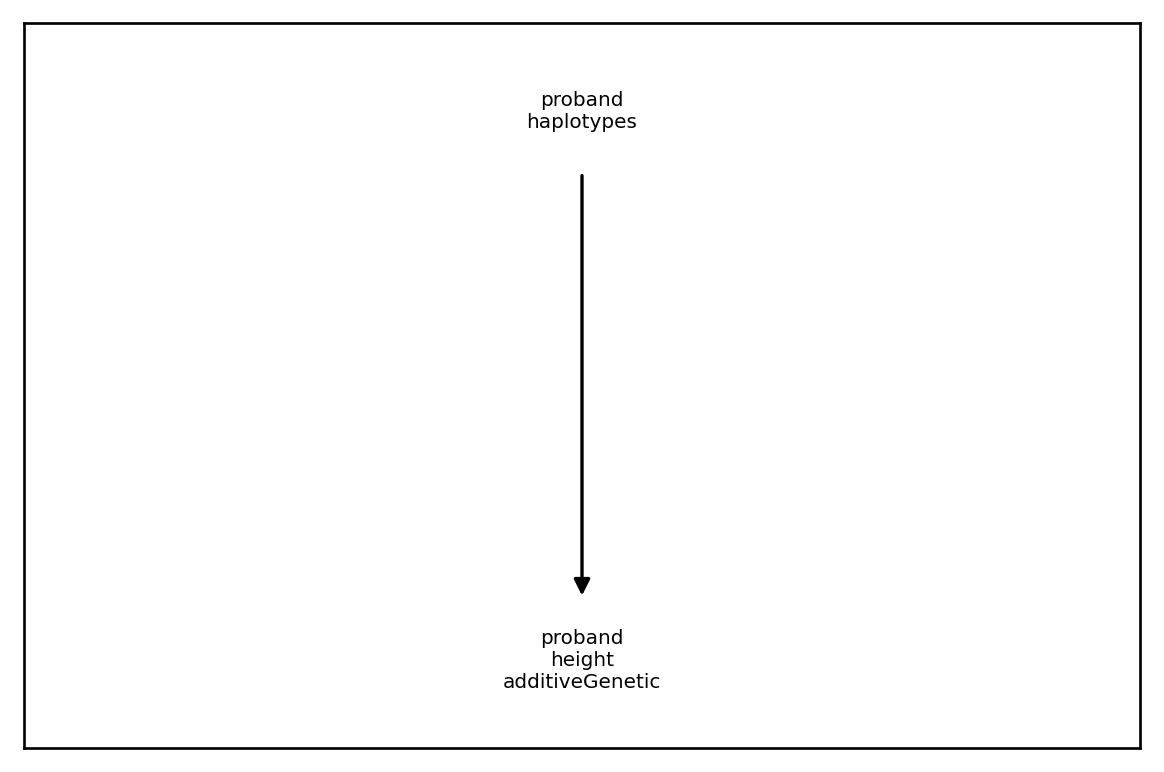

In [48]:
arch = xft.arch.AdditiveGeneticComponent(effects)
arch.draw_dependency_graph()
arch

## Noise components

Noise components are likely the simplest archetectural component to specify. For iid Gaussian noise, we only need to provide variances (or standard deviations if preferred) and the names of the corresponding phenotypes to the `AdditiveNoiseComponent` constructor. Here we construct independent noise components for height and BMD with variances 0.5 and 0.6, respectively:

In [49]:
inoise = xft.arch.AdditiveNoiseComponent(variances=[.5,.6], phenotype_name=['height', 'BMD'])
inoise

<class 'xftsim.arch.AdditiveNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                             phenotype_name component_name  vorigin_relative  \
component                                                                      
height.additiveNoise.proband         height  additiveNoise                -1   
BMD.additiveNoise.proband               BMD  additiveNoise                -1   

                                 comp_type  
component                                   
height.additiveNoise.proband  intermediate  
BMD.additiveNoise.proband     intermediate  

If we want (possibly correlated) multivariate normal noise components, we can use `CorrelatedNoiseComponent` instead. Here we set the correlation between the noise components for height and BMD to 0.3:

In [50]:
vcov = np.array([[.5, .3*np.sqrt(.5*.6)],
                 [.3*np.sqrt(.5*.6), .6]])

cnoise = xft.arch.CorrelatedNoiseComponent(vcov=vcov, phenotype_name=['height', 'BMD'])
cnoise

<class 'xftsim.arch.CorrelatedNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.correlatedNoise.proband         height  correlatedNoise   
BMD.correlatedNoise.proband               BMD  correlatedNoise   

                                vorigin_relative     comp_type  
component                                                       
height.correlatedNoise.proband                -1  intermediate  
BMD.correlatedNoise.proband                   -1  intermediate  

## Causal dependencies 

### Univariate causal dependence

We use the term "causal dependences" to refer to scenarios where one phenotype component is directly affected by another within an individual. For example, suppose I want to model years of education and income. It may reasonable to assume that regardless whatever individual heritable and/or non-heritable influences on either outcome, years of education will have some possitve effect on income (i.e., advanced degrees increase earnings). 

For simplicity, we will assume that neither trait is heritable, but that 50% of the variance in income is a linear function of years of education (which we treat here as continous for simplicity). I can model this dependence using `LinearTransformationComponent`.

One (very simple) generative model might look like this

$$\text{Edu}_\text{noise}\sim N(0,1)$$
$$\text{Income}_\text{noise}\sim N(0,.5)$$
$$\text{Edu} = \text{Edu}_\text{noise}$$
$$\text{Income}=\text{Income}_\text{noise} +\text{Edu}_\text{noise}\sqrt{.5}$$


First, we'll model the independent parts of our phenotypes. We want education to be completely random so we'll set it's variance to 1.0, whereas the independent noise for income will have variance 0.5:


In [51]:
ncomp = xft.arch.AdditiveNoiseComponent(variances=[1,.5], 
                                        phenotype_name=['edu', 'income'])
ncomp

<class 'xftsim.arch.AdditiveNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                             phenotype_name component_name  vorigin_relative  \
component                                                                      
edu.additiveNoise.proband               edu  additiveNoise                -1   
income.additiveNoise.proband         income  additiveNoise                -1   

                                 comp_type  
component                                   
edu.additiveNoise.proband     intermediate  
income.additiveNoise.proband  intermediate  

Next, we'll add a `LinearTransformationComponent`, which requires the following arguments:
 - `input_cindex`: the ComponentIndex for the independent variable(s)
 - `output_cindex`: the ComponentIndex for the dependent variable(s)
 - `coefficient_matrix`: the matrix to premultiply the independent variables with to get the dependent variables
 - `normalize`: a boolean flag determining whether or not to standardize the independent variables prior to applying the linear transformation.
 
This will be very simple in this case as our matrix is 1x1:


In [52]:
input_ind = xft.index.ComponentIndex(['edu'], ['additiveNoise'])
output_ind = xft.index.ComponentIndex(['income'], ['dependentComponent'])
coefficient_matrix = np.array([[np.sqrt(.5)]])

ccomp = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
ccomp

<LinearTransformationComponent>
                                           normalized_edu additiveNoise -1 intermediate
income_dependentComponent_-1_intermediate                                      0.707107

To put everything together, can add a `SumAllTransformation`, which we'll cover in greater depth below:

<class 'xftsim.arch.SumAllTransformation'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<ComponentIndex>
  2 components of 2 phenotypes spanning 1 generation
                                  phenotype_name      component_name  \
component                                                              
edu.additiveNoise.proband                    edu       additiveNoise   
income.additiveNoise.proband              income       additiveNoise   
income.dependentComponent.proband         income  dependentComponent   

                                   vorigin_relative     comp_type  
component                                                          
edu.additiveNoise.proband                        -1  intermediate  
income.additiveNoise.proband                     -1  intermediate  
income.dependentComponent.proband                -1  intermediate  

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                     

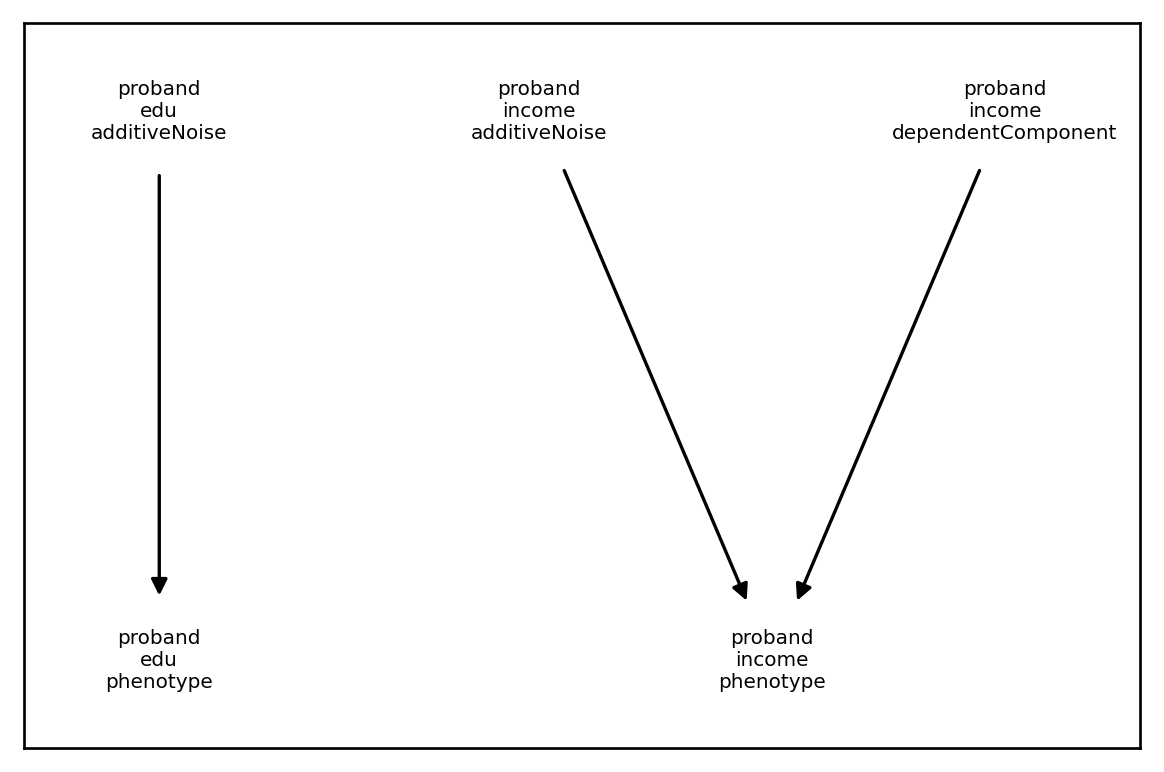

In [53]:
iind = xft.index.ComponentIndex(['edu','income','income'], 
                                ['additiveNoise','additiveNoise','dependentComponent'])

strans = xft.arch.SumAllTransformation(input_cindex=iind) 
strans.draw_dependency_graph()
strans

Looking at the result, we see that everything is is as expected:

phenotype_name                                               edu  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               1.000000   
income         additiveNoise      proband               0.000409   
               dependentComponent proband               1.000000   
edu            phenotype          proband               1.000000   
income         phenotype          proband               0.486797   

phenotype_name                                            income  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               0.000409   
income         additiveNoise      proband               1.000000   
               dependentComponent proband               0.000409   
edu            phenotype          proband               0.000409   
income         phenotype          proband               0.492984   

phenotype_name                                                         \
component_name                                     dependentComponent   
vorigin_relative                                              proband   
phenotype_name component_name     vorigin_relative                      
edu            additiveNoise      proband                    1.000000   
income         additiveNoise      proband                    0.000409   
               dependentComponent proband                    1.000000   
edu            phenotype          proband                    1.000000   
income         phenotype          proband                    0.486797   

phenotype_name                                           edu    income  
component_name                                     phenotype phenotype  
vorigin_relative                                     proband   proband  
phenotype_name component_name     vorigin_relative                      
edu            additiveNoise      proband           1.000000  0.486797  
income         additiveNoise      proband           0.000409  0.492984  
               dependentComponent proband           1.000000  0.486797  
edu            phenotype          proband           1.000000  0.486797  
income         phenotype          proband           0.486797  1.000000

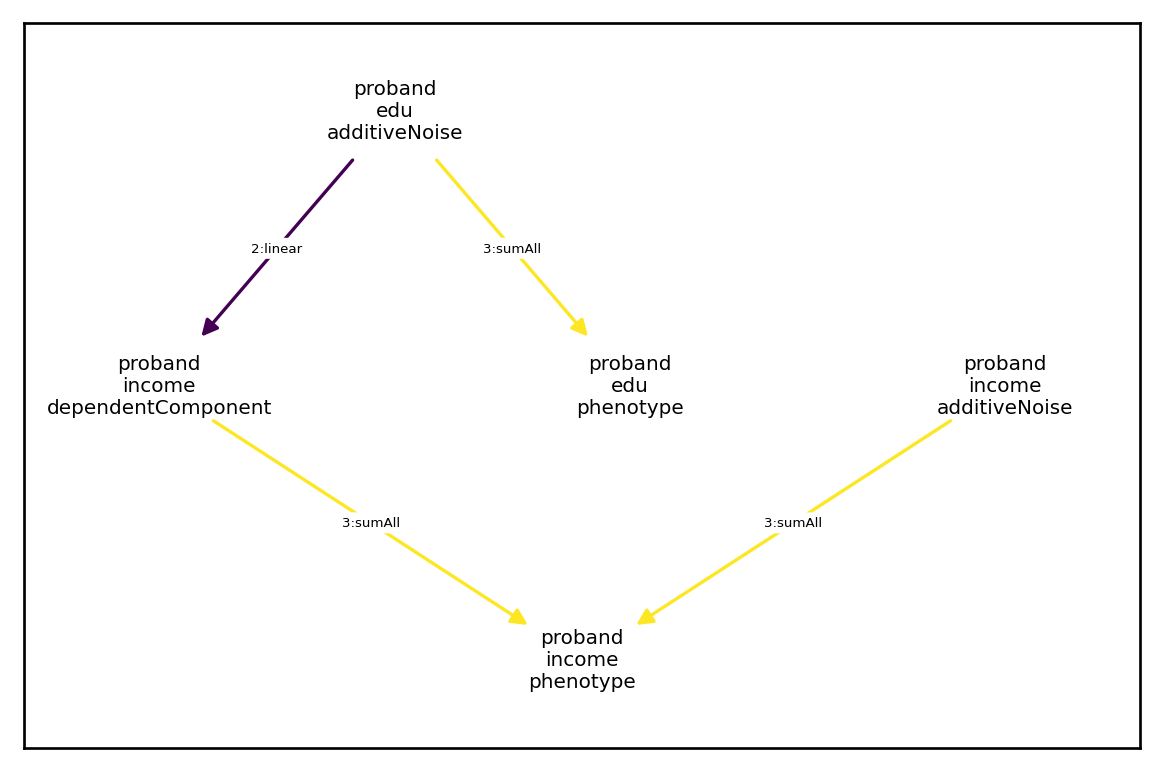

In [54]:
demo =  xft.sim.DemoSimulation()

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, ccomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)

test_sim.architecture.draw_dependency_graph()
test_sim.run(1)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2

### Multivariate causal dependence


No suppose we assume income is affected by not just a single education factor, but by education and some measure of "opportunity".

Another simple model generative model might look like this

$$\text{Edu}_\text{noise}\sim N(0,1)$$
$$\text{Opportunity}_\text{noise}\sim N(0,1)$$
$$\text{Income}_\text{noise}\sim N(0,.5)$$
$$\text{Income}=\text{Income}_\text{noise} +\text{Edu}_\text{noise}\sqrt{.25} +\text{Opportunity}_\text{noise}\sqrt{.25}$$

In this case, everything will be the same except that our linear transformation will be 2x1:


phenotype_name                                               edu  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               1.000000   
opportunity    additiveNoise      proband               0.000800   
income         additiveNoise      proband               0.001326   
               dependentComponent proband               0.514143   
edu            phenotype          proband               1.000000   
opportunity    phenotype          proband               0.000800   
income         phenotype          proband               0.272445   

phenotype_name                                       opportunity  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               0.000800   
opportunity    additiveNoise      proband               1.000000   
income         additiveNoise      proband               0.000165   
               dependentComponent proband               0.514143   
edu            phenotype          proband               0.000800   
opportunity    phenotype          proband               1.000000   
income         phenotype          proband               0.255555   

phenotype_name                                            income  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               0.001326   
opportunity    additiveNoise      proband               0.000165   
income         additiveNoise      proband               1.000000   
               dependentComponent proband               0.001181   
edu            phenotype          proband               0.001326   
opportunity    phenotype          proband               0.000165   
income         phenotype          proband               0.521016   

phenotype_name                                                         \
component_name                                     dependentComponent   
vorigin_relative                                              proband   
phenotype_name component_name     vorigin_relative                      
edu            additiveNoise      proband                    0.514143   
opportunity    additiveNoise      proband                    0.514143   
income         additiveNoise      proband                    0.001181   
               dependentComponent proband                    1.000000   
edu            phenotype          proband                    0.514143   
opportunity    phenotype          proband                    0.514143   
income         phenotype          proband                    0.513345   

phenotype_name                                           edu opportunity  \
component_name                                     phenotype   phenotype   
vorigin_relative                                     proband     proband   
phenotype_name component_name     vorigin_relative                         
edu            additiveNoise      proband           1.000000    0.000800   
opportunity    additiveNoise      proband           0.000800    1.000000   
income         additiveNoise      proband           0.001326    0.000165   
               dependentComponent proband           0.514143    0.514143   
edu            phenotype          proband           1.000000    0.000800   
opportunity    phenotype          proband           0.000800    1.000000   
income         phenotype          proband           0.272445    0.255555   

phenotype_name                                        income  
component_name                                   

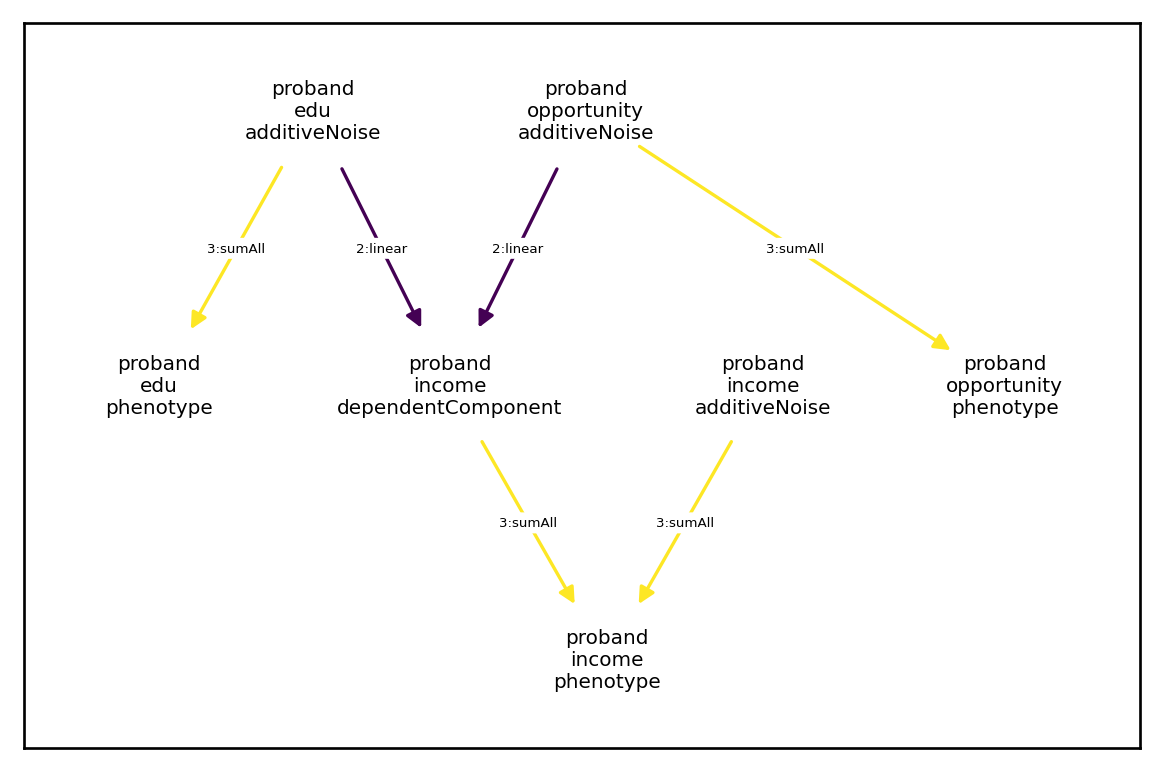

In [56]:
ncomp = xft.arch.AdditiveNoiseComponent(variances=[1,1,.5], 
                                        phenotype_name=['edu', 'opportunity', 'income'])
input_ind = xft.index.ComponentIndex(['edu','opportunity'], ['additiveNoise','additiveNoise'])
output_ind = xft.index.ComponentIndex(['income'], ['dependentComponent'])
coefficient_matrix = np.array([[np.sqrt(.25),np.sqrt(.25)]])

ccomp = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
sind = xft.index.ComponentIndex(['edu','opportunity','income','income'], 
                                ['additiveNoise','additiveNoise','additiveNoise','dependentComponent'])

strans = xft.arch.SumAllTransformation(input_cindex=sind) 

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, ccomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)

test_sim.architecture.draw_dependency_graph()
test_sim.run(1)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2

## Vertical transmission

### Univariate vertical transimission

Vertical transmission refers to causal dependence across parent and offspring generations. For example, we might want to model the inheritance of wealth across generations. One generative generative model could look like this:

$$\text{Wealth}_\text{noise}\sim N(0,.5)$$
$$\text{Wealth}_\text{vertical} = (\text{Wealth}_\text{maternal} + \text{Wealth}_\text{paternal})\sqrt{(1/4)}$$
$$\text{Wealth}_\text{phenotype} = \text{Wealth}_\text{vertical} + \text{Wealth}_\text{noise}$$

I.e., half of wealth is individual specific noise and half is inherited from ones parents. 

Specifying a linear transmission like this is quite similar to the previous example of causal dependencies, only the inputs refer to parent generation (as specified by `vorigin_relative`; see [the tutorial on component indexing for further details](./indexing.ipynb)) rather than the offspring generation. However, in addition to specifying the transmission as a linear opeartion, **we have to specify a way to initialize the transmitted component in the founder generation**. By default, we set to this to independent Gaussian noise with user-supplied variance $\sigma^2_\text{founder}$ such that $\text{Wealth}_\text{vertical}$ is drawn from this distribution in the first generation (when, in the context of our simulation, no parents exist to pass on wealth).

We demonstrate this below:

<LinearVerticalComponent>
                                 wealth phenotype 0 output  \
wealth_vertical_-1_intermediate                        0.5   

                                 wealth phenotype 1 output  
wealth_vertical_-1_intermediate                        0.5  

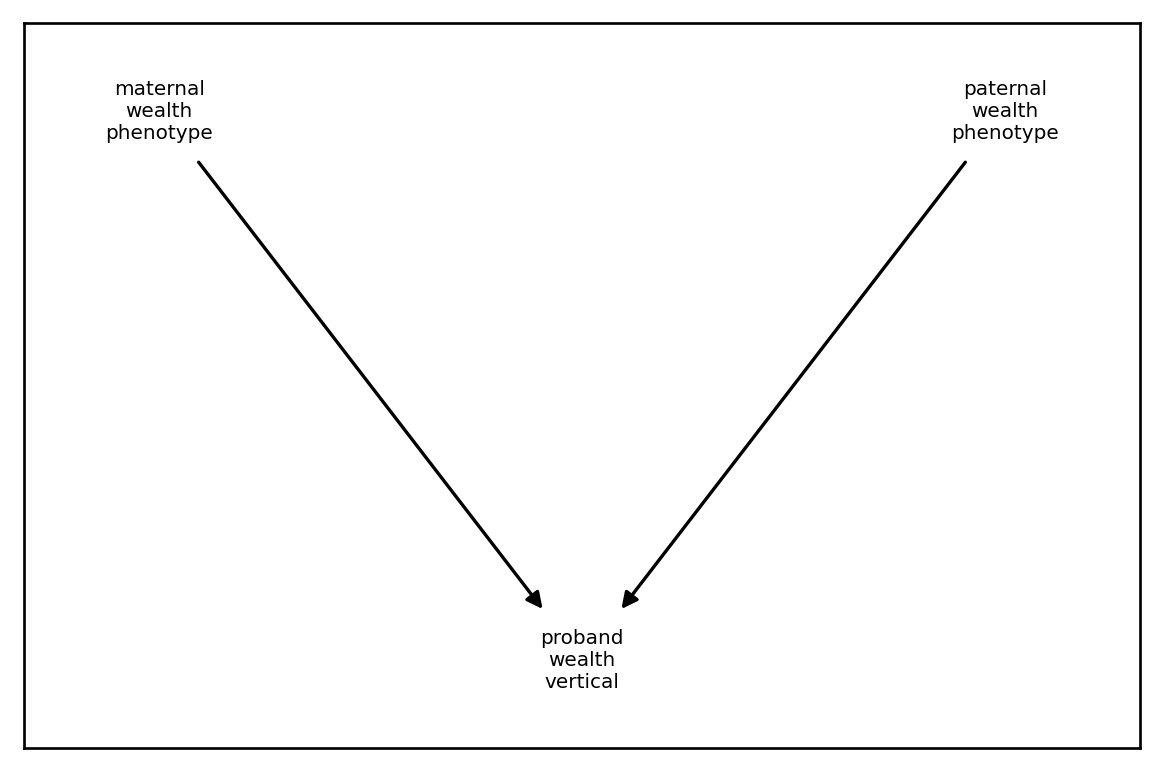

In [57]:
## noise component
ncomp = xft.arch.AdditiveNoiseComponent(variances=[.5], 
                                        phenotype_name=['wealth'])

## transmitted component:
vert_input = xft.index.ComponentIndex.from_product(['wealth'], ['phenotype'], [0,1])
vert_input.comp_type ='output'
vert_output = xft.index.ComponentIndex.from_product(['wealth'], ['vertical'], [-1])
founder_variances = np.sqrt([.5,.5]) ## must be same length is inputs
coefficient_matrix = np.array([[np.sqrt(.25),np.sqrt(.25)]])

vtcomp = xft.arch.LinearVerticalComponent(input_cindex=vert_input,
                                          output_cindex=vert_output,
                                          founder_variances=founder_variances,
                                          coefficient_matrix=coefficient_matrix,
                                          normalize = False)
vtcomp.draw_dependency_graph()
vtcomp

phenotype_name                                        wealth            \
component_name                                 additiveNoise phenotype   
vorigin_relative                                     proband    mother   
phenotype_name component_name vorigin_relative                           
wealth         additiveNoise  proband               1.000000  0.000154   
               phenotype      mother                0.000154  1.000000   
                              father                0.001868  0.000735   
               vertical       proband               0.000524  0.477947   
               phenotype      proband               0.522825  0.237035   

phenotype_name                                                                
component_name                                            vertical phenotype  
vorigin_relative                                  father   proband   proband  
phenotype_name component_name vorigin_relative                                
wealth         additiveNoise  proband           0.001868  0.000524  0.522825  
               phenotype      mother            0.000735  0.477947  0.237035  
                              father            1.000000  0.549101  0.230472  
               vertical       proband           0.549101  1.000000  0.454331  
               phenotype      proband           0.230472  0.454331  1.000000

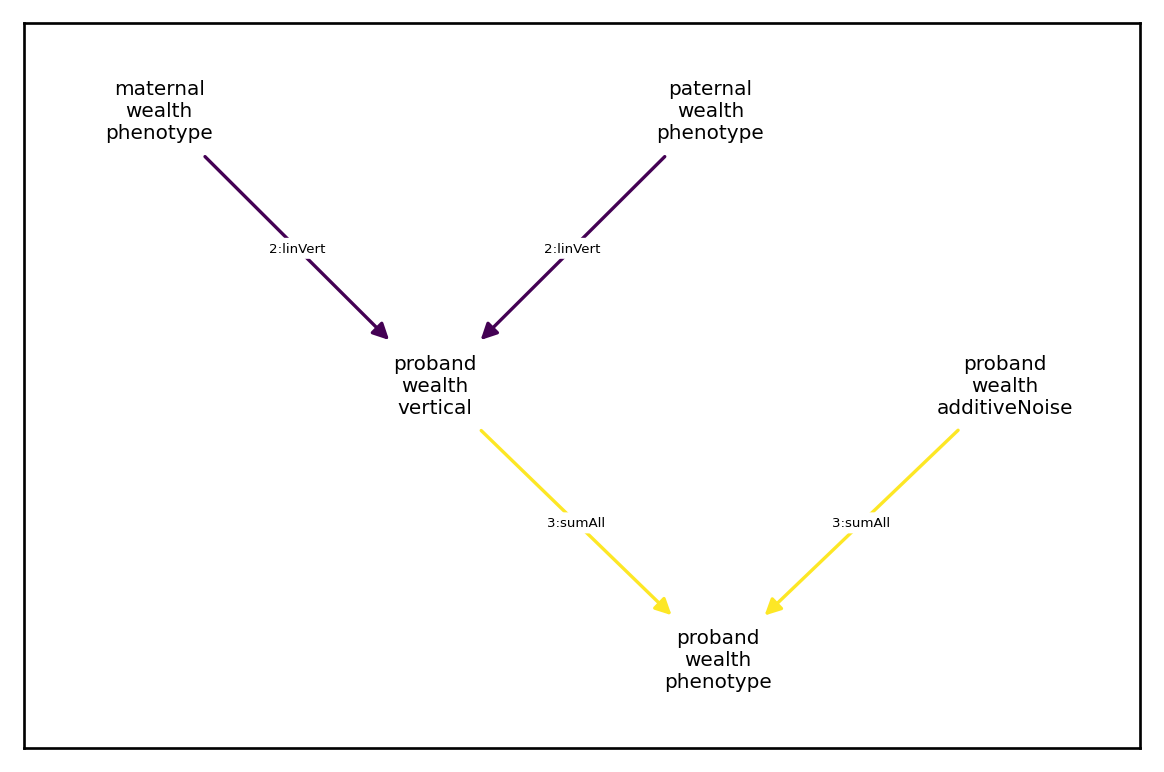

In [58]:

sind = xft.index.ComponentIndex.from_product(['wealth'],
                                             ['additiveNoise','vertical'])

strans = xft.arch.SumAllTransformation(input_cindex=sind) 

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, vtcomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)
test_sim.architecture.draw_dependency_graph()
test_sim.run(2)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2


### Multivariate vertical transimission

We might have more complex patterns of inheritance. For example, consider the following generative model:


$$\text{Edu}_\text{noise}\sim N(0,.5)$$
$$\text{Wealth}_\text{noise}\sim N(0,.5)$$
$$\text{Edu}_\text{phenotype}=\text{Edu}_\text{inherited}+\text{Edu}_\text{noise}$$
$$\text{Wealth}_\text{phenotype}=\text{Wealth}_\text{inherited}+\text{Wealth}_\text{noise}$$


where 
$$\begin{pmatrix}\text{Edu}_{\text{inherited}}\\
\text{Wealth}_{\text{inherited}}
\end{pmatrix}\stackrel{iid}{\sim}N(0,1/2)$$
at generation zero and 
$$
\begin{pmatrix}\text{Edu}_{\text{inherited}}\\
\text{Wealth}_{\text{inherited}}
\end{pmatrix}=\begin{pmatrix}2^{-1} & 2^{-1} & 0 & 0\\
2^{-3/2} & 2^{-3/2} & 2^{-3/2} & 2^{-3/2}
\end{pmatrix}\begin{pmatrix}\tilde{\text{Edu}}_{\text{maternal}}\\
\tilde{\text{Edu}}_{\text{paternal}}\\
\tilde{\text{Wealth}}_{\text{maternal}}\\
\tilde{\text{Wealth}}_{\text{paternal}}
\end{pmatrix}$$every subsequent generation, where $\tilde{[\cdot]}$ denotes a standardized quantity. Under this model, half the variance in wealth and education are both independent Gaussian noise, half the variance in education is attributable to parental education, and a quarter each of the variance in wealth is attributable to parental education and parental wealth, respectively. We code this as follows:



<LinearVerticalComponent>
                                    normalized_education phenotype 0 output  \
education_vertical_-1_intermediate                                 0.500000   
wealth_vertical_-1_intermediate                                    0.353553   

                                    normalized_education phenotype 1 output  \
education_vertical_-1_intermediate                                 0.500000   
wealth_vertical_-1_intermediate                                    0.353553   

                                    normalized_wealth phenotype 0 output  \
education_vertical_-1_intermediate                              0.000000   
wealth_vertical_-1_intermediate                                 0.353553   

                                    normalized_wealth phenotype 1 output  
education_vertical_-1_intermediate                              0.000000  
wealth_vertical_-1_intermediate                                 0.353553  

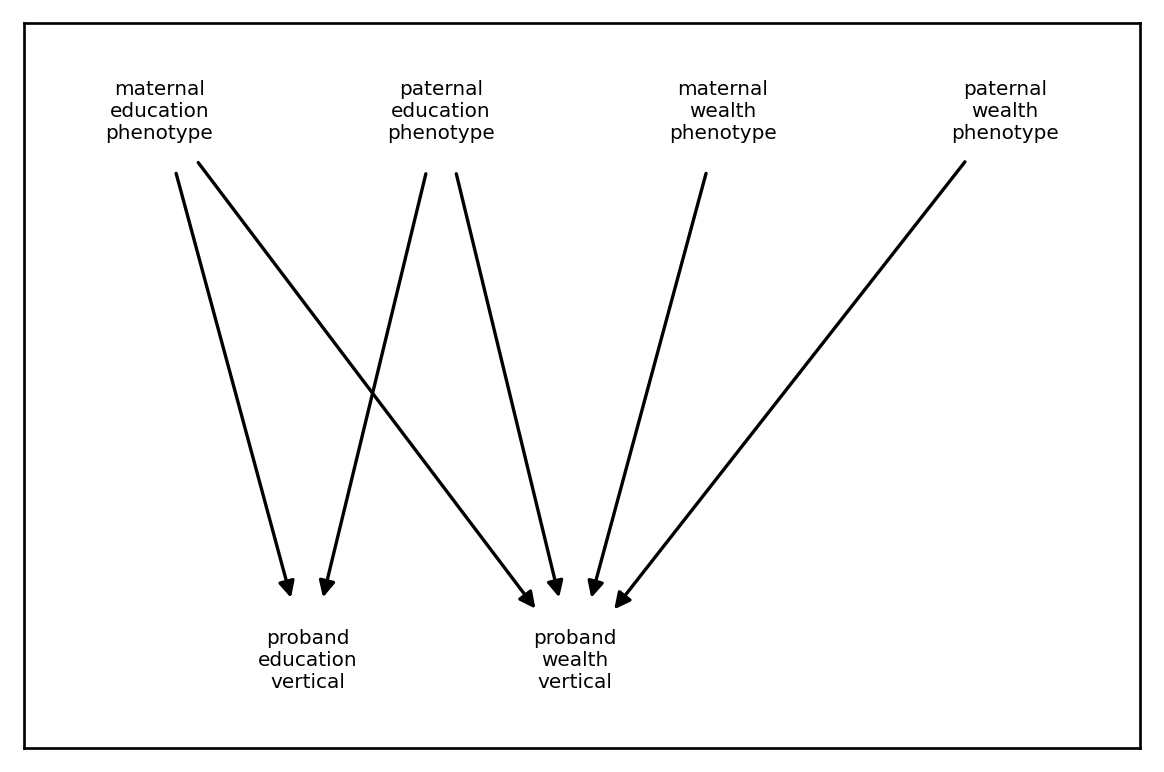

In [59]:
## noise component
ncomp = xft.arch.AdditiveNoiseComponent(variances=[.5,.5], 
                                        phenotype_name=['education', 'wealth'])

## transmitted component:
vert_input = xft.index.ComponentIndex.from_product(['education', 'wealth'], ['phenotype'], [0,1])
vert_input.comp_type ='output'
vert_output = xft.index.ComponentIndex.from_product(['education', 'wealth'], ['vertical'], [-1])
founder_variances = np.sqrt([.5,.5,.5,.5]) ## must be same length is inputs
coefficient_matrix = np.array([[np.sqrt(.25),np.sqrt(.125)],
                               [np.sqrt(.25),np.sqrt(.125)],
                               [np.sqrt(0),np.sqrt(.125)],
                               [np.sqrt(0),np.sqrt(.125)],
                              ]).T

vtcomp = xft.arch.LinearVerticalComponent(input_cindex=vert_input,
                                          output_cindex=vert_output,
                                          founder_variances=founder_variances,
                                          coefficient_matrix=coefficient_matrix,
                                          normalize = True)
vtcomp.draw_dependency_graph()
vtcomp

In [60]:

sind = xft.index.ComponentIndex.from_product(['education','wealth'],
                                             ['additiveNoise','vertical'])

strans = xft.arch.SumAllTransformation(input_cindex=sind) 

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, vtcomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)

test_sim.run(1)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2

phenotype_name                                     education        wealth  \
component_name                                 additiveNoise additiveNoise   
vorigin_relative                                     proband       proband   
phenotype_name component_name vorigin_relative                               
education      additiveNoise  proband               1.000000      0.001552   
wealth         additiveNoise  proband               0.001552      1.000000   
education      phenotype      mother                0.000064      0.001915   
                              father                0.000131      0.000274   
wealth         phenotype      mother                0.000094      0.000187   
                              father                0.000459      0.000024   
education      vertical       proband               0.000191      0.000374   
wealth         vertical       proband               0.000248      0.000019   
education      phenotype      proband               0.501904      0.000193   
wealth         phenotype      proband               0.001547      0.513517   

phenotype_name                                 education              wealth  \
component_name                                 phenotype           phenotype   
vorigin_relative                                  mother    father    mother   
phenotype_name component_name vorigin_relative                                 
education      additiveNoise  proband           0.000064  0.000131  0.000094   
wealth         additiveNoise  proband           0.001915  0.000274  0.000187   
education      phenotype      mother            1.000000  0.000091  0.000067   
                              father            0.000091  1.000000  0.000449   
wealth         phenotype      mother            0.000067  0.000449  1.000000   
                              father            0.000017  0.000003  0.000367   
education      vertical       proband           0.495235  0.495235  0.000085   
wealth         vertical       proband           0.256438  0.238703  0.238891   
education      phenotype      proband           0.252311  0.254718  0.000176   
wealth         phenotype      proband           0.103503  0.124382  0.123017   

phenotype_name                                           education    wealth  \
component_name                                            vertical  vertical   
vorigin_relative                                  father   proband   proband   
phenotype_name component_name vorigin_relative                                 
education      additiveNoise  proband           0.000459  0.000191  0.000248   
wealth         additiveNoise  proband           0.000024  0.000374  0.000019   
education      phenotype      mother            0.000017  0.495235  0.256438   
                              father            0.000003  0.495235  0.238703   
wealth         phenotype      mother            0.000367  0.000085  0.238891   
                              father            1.000000  0.000003  0.246482   
education      vertical       proband           0.000003  1.000000  0.499745   
wealth         vertical       proband           0.246482  0.499745  1.000000   
education      phenotype      proband           0.000260  0.511904  0.260069   
wealth         phenotype      proband           0.122384  0.229594  0.482133   

phenotype_name                                 education    wealth  
component_name                                 phenotype phenotype  
vorigin_relative                                 proband   proband  
phenotype_name component_name vorigin_relative                      
education      additiveNoise  proband           0.501904  0.001547  
wealth         additiveNoise  proband           0.000193  0.513517  
education      phenotype      mother            0.252311  0.103503  
                              father            0.254718  0.124382  
wealth         phenotype      mother            0.000176  0.123017  
                              father        

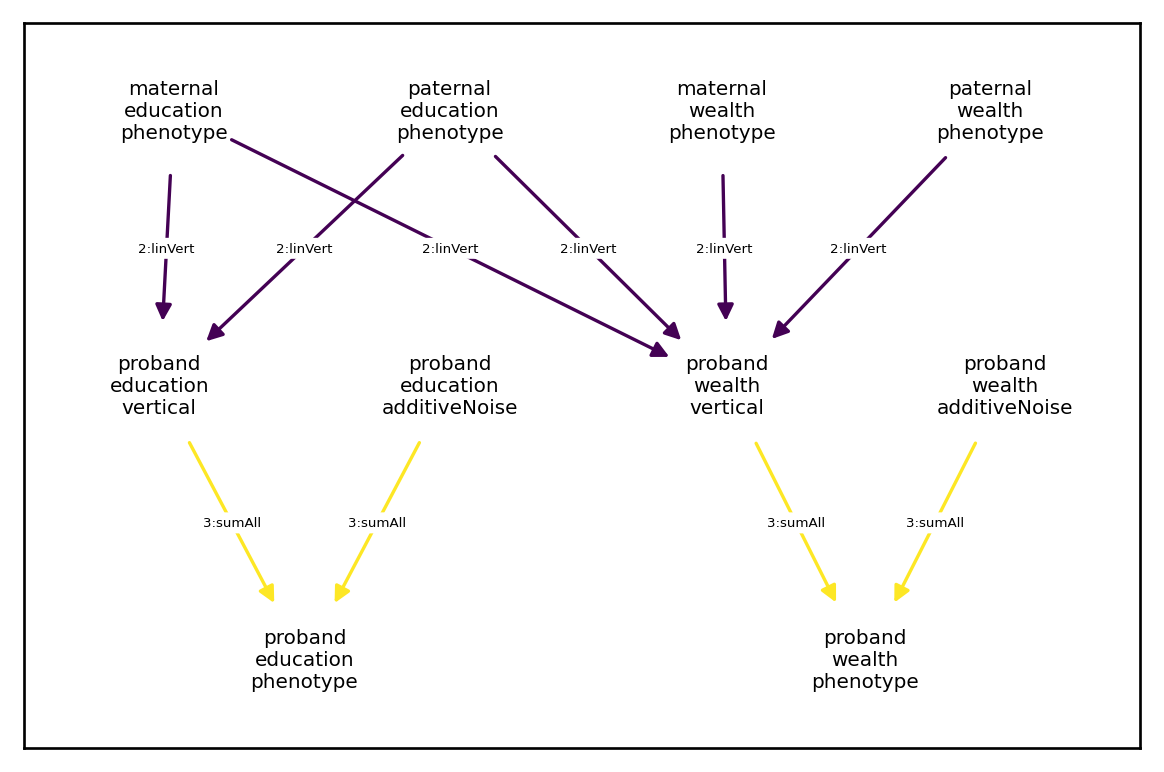

In [61]:
xft.arch.Architecture([ncomp, vtcomp, strans]).draw_dependency_graph()

## Sum transformations

We nearly always will want to include a component that sums existing components to create composite phenotypes. This is straight forward to accomplish using the `SumAllTransformation` component. To specify a `SumAllTransformation`, we only need to provide the input component index and it will sum input components corresponding to the same phenotype:


<class 'xftsim.arch.SumAllTransformation'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<ComponentIndex>
  5 components of 2 phenotypes spanning 1 generation
                       phenotype_name component_name  vorigin_relative  \
component                                                                
BMD.BMD1.proband                  BMD           BMD1                -1   
BMD.BMD2.proband                  BMD           BMD2                -1   
BMD.BMD3.proband                  BMD           BMD3                -1   
height.height1.proband         height        height1                -1   
height.height2.proband         height        height2                -1   

                           comp_type  
component                             
BMD.BMD1.proband        intermediate  
BMD.BMD2.proband        intermediate  
BMD.BMD3.proband        intermediate  
height.height1.proband  intermediate  
height.height2.proband  intermediate  

## OUTPUTS:
 - phenotype components:

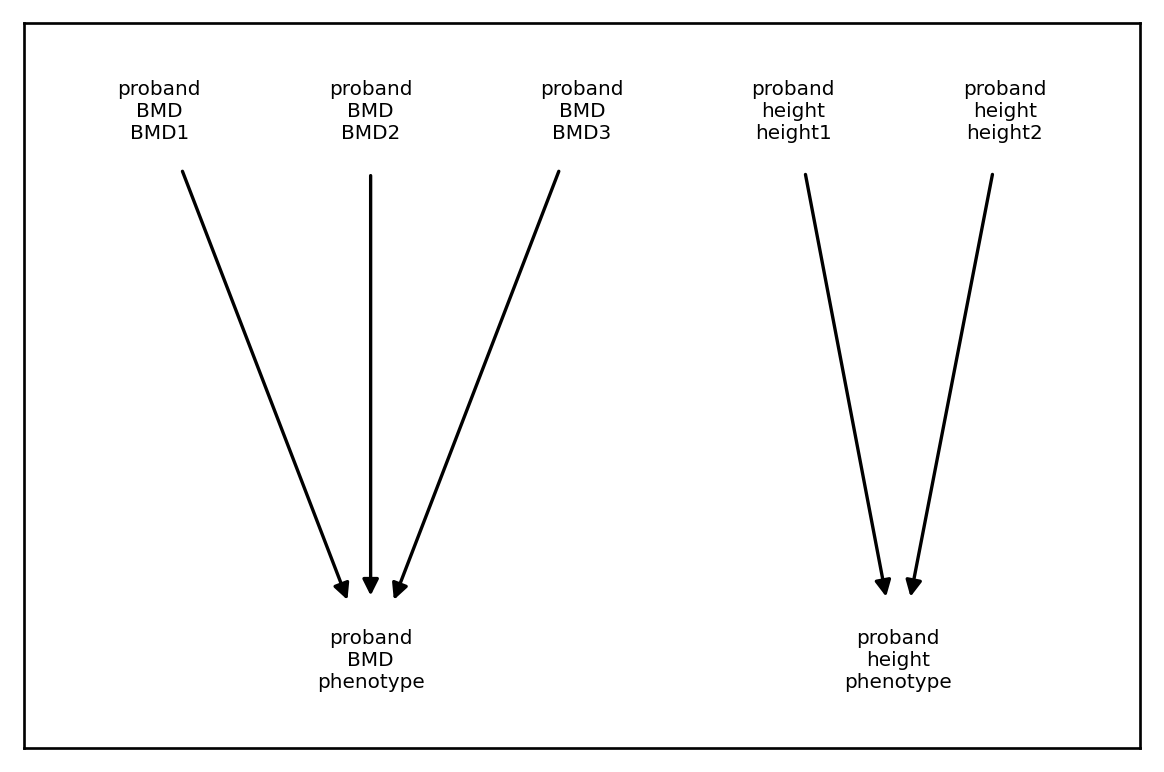

In [62]:
input_cindex=xft.index.ComponentIndex(['BMD', 'BMD', 'BMD', 'height', 'height'], 
                                      ['BMD1', 'BMD2', 'BMD3', 'height1', 'height2'])

strans = xft.arch.SumAllTransformation(input_cindex)
strans.draw_dependency_graph()
strans

## Binarizations

:::{note}

Coming soon

:::

## Architecture objects: order matters

As we have seen throughout, an `Architecture` object is nothing more than a collection of `ArchitectureComponents`. These components are constructed in order (e.g., you can't sum components that don't yet exist), and can be arbitrarily complicated. We demonstrate a complex simulation below:

![Complex simulation](../_static/complexsim.png)

Here we assume that height is heritable with heritability 0.6, but that educational attainment and wealth are not. On the other hand, we assume that the variation in educational attainment is attributable in equal parts to parental educational attainment, parental wealth, and random noise. We also assume that an individual's wealth is determined in equal parts by their own educational attainment, their parent's wealth, and random noise. Thus we have additive genetic, additive noise, multivariate vertical transmission, and causal dependence. We try to implement this in `xftsim` as follows: 


In [63]:
## This example won't work
founder_haplotypes = xft.founders.founder_haplotypes_uniform_AFs(n=4000,
                                                                 m=800)
rmap = xft.reproduce.RecombinationMap.constant_map_from_haplotypes(founder_haplotypes,
                                                                   .1)

genetic_effects = xft.effect.GCTAEffects(vg=[.6],
                                         variant_indexer=founder_haplotypes.xft.get_variant_indexer(),
                                         component_indexer=xft.index.ComponentIndex(['height'],
                                                                                    ['genetic']))
genetic_comp = xft.arch.AdditiveGeneticComponent(genetic_effects)

noise_comp = xft.arch.AdditiveNoiseComponent(variances=[.4,1/3,1/3],
                                             component_index=xft.index.ComponentIndex.from_product(['height','edu','wealth'],
                                                                                                   ['noise']))
vert_input = xft.index.ComponentIndex.from_product(['edu', 'wealth'], ['phenotype'], [0,1])
vert_input.comp_type ='output'
vert_output = xft.index.ComponentIndex.from_product(['edu', 'wealth'], ['vertical'], [-1])
founder_variances = np.sqrt([.5,.5,.5,.5]) ## must be same length is inputs
coefficient_matrix = np.array([[np.sqrt(1/3),np.sqrt(1/6)],
                               [np.sqrt(1/3),np.sqrt(1/6)],
                               [np.sqrt(0),np.sqrt(1/6)],
                               [np.sqrt(0),np.sqrt(1/6)],
                              ]).T

vt_comp = xft.arch.LinearVerticalComponent(input_cindex=vert_input,
                                          output_cindex=vert_output,
                                          founder_variances=[1.,1.,1.,1.,],
                                          coefficient_matrix=coefficient_matrix,
                                          normalize = True)
input_ind = xft.index.ComponentIndex(['edu'], ['phenotype'])
output_ind = xft.index.ComponentIndex(['wealth'], ['dependent'])
coefficient_matrix = np.array([[np.sqrt(1/3)]])

causal_comp = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
input_cindex=xft.index.ComponentIndex(['height','height','edu', 'edu', 'wealth', 'wealth','wealth'], 
                                      ['genetic','noise','noise', 'vertical', 'noise', 'vertical','dependent'])

strans = xft.arch.SumAllTransformation(input_cindex)

arch = xft.arch.Architecture([genetic_comp,
                              noise_comp,
                              causal_comp,
                              vt_comp,
                              strans])


/home/rsb/Dropbox/ftsim/xftsim/xftsim/arch.py:1522: UserWarning: Architecture contains circular dependencies! This is probably a mistake, check dependency_graph using xft.arch.Architecture.draw_dependency_graph()
  warnings.warn('Architecture contains circular dependencies! This is probably a mistake, check dependency_graph using xft.arch.Architecture.draw_dependency_graph()')


In [64]:
mating = xft.mate.LinearAssortativeMatingRegime(r=.25,
                                                component_index =xft.index.ComponentIndex.from_product(['edu', 'wealth','height'], ['phenotype']), 
                                                offspring_per_pair=2,
                                                mates_per_female=1)

In [65]:
sim = xft.sim.Simulation(architecture=arch,
                   founder_haplotypes=founder_haplotypes,
                   recombination_map=rmap,
                   mating_regime=mating,
                   statistics=[xft.stats.SampleStatistics(),
                               xft.stats.MatingStatistics(),
                               xft.stats.HasemanElstonEstimator(randomized=True)])
sim.run(1)
sim.phenotypes.xft.as_pd()

phenotype_name       height                 edu    wealth       edu    wealth  \
component_name      genetic     noise     noise     noise phenotype dependent   
vorigin_relative    proband   proband   proband   proband   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0    0.584003  0.113694 -0.108228 -0.115163 -1.753643       NaN   
0_1    0_1    1   -0.218097 -1.250484  0.137125 -1.028808  0.014015       NaN   
0_2    0_2    0   -0.229252  0.503652 -0.265787 -0.414191 -1.005683       NaN   
0_3    0_3    1   -0.059315 -0.444491  1.218706  0.810719  0.385027       NaN   
0_4    0_4    0    0.290709 -0.044305 -0.905316  1.493687 -1.939863       NaN   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1   -1.007374  0.141846 -0.142301 -0.512005 -0.762751       NaN   
0_3996 0_3996 0    0.092540  1.295842 -0.550509  0.407380 -1.225387       NaN   
0_3997 0_3997 1   -0.332271  0.763553  1.493676 -0.151551  0.739690       NaN   
0_3998 0_3998 0   -1.388650  0.104217  0.211394  0.309108  0.320138       NaN   
0_3999 0_3999 1    1.567026 -0.915476  0.133127  0.699371 -0.024441       NaN   

phenotype_name          edu              wealth                 edu    wealth  \
component_name    phenotype           phenotype            vertical  vertical   
vorigin_relative     mother    father    mother    father   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0   -1.964481 -0.880274 -0.483069  0.603101 -1.645415 -1.124082   
0_1    0_1    1   -0.133511 -0.075062  0.390639  1.025959 -0.123110  0.480507   
0_2    0_2    0   -0.657283 -0.612858 -1.983980  0.463108 -0.739896 -1.155121   
0_3    0_3    1   -0.867872 -0.567599  2.177881 -1.266897 -0.833679 -0.212202   
0_4    0_4    0    0.078990 -1.826752 -0.036831 -0.836798 -1.034547 -1.088667   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1   -0.389175 -0.670398  0.367932 -0.130813 -0.620450 -0.345930   
0_3996 0_3996 0    0.129700 -1.266048 -0.459688  0.891860 -0.674879 -0.312038   
0_3997 0_3997 1   -2.069135  0.732866 -0.377470 -0.329811 -0.753986 -0.825859   
0_3998 0_3998 0   -0.240272  0.421666 -0.881282 -0.000396  0.108744 -0.289708   
0_3999 0_3999 1    0.118551 -0.378016  0.204603  0.786063 -0.157569  0.283382   

phenotype_name       height    wealth  
component_name    phenotype phenotype  
vorigin_relative    proband   proband  
iid    fid    sex                      
0_0    0_0    0    0.697697       NaN  
0_1    0_1    1   -1.468581       NaN  
0_2    0_2    0    0.274400       NaN  
0_3    0_3    1   -0.503806       NaN  
0_4    0_4    0    0.246404       NaN  
...                     ...       ...  
0_3995 0_3995 1   -0.865528       NaN  
0_3996 0_3996 0    1.388382       NaN  
0_3997 0_3997 1    0.431281       NaN  
0_3998 0_3998 0   -1.284433       NaN  
0_3999 0_3999 1    0.651550       NaN  

[4000 rows x 14 columns]

It looks like the simulation wasn't able to compute the 'dependent' or 'phenotype' components of 'wealth'. What happened here? Looking at the dependency graph (which colors edges in order of computation) we see we have a circular dependency:

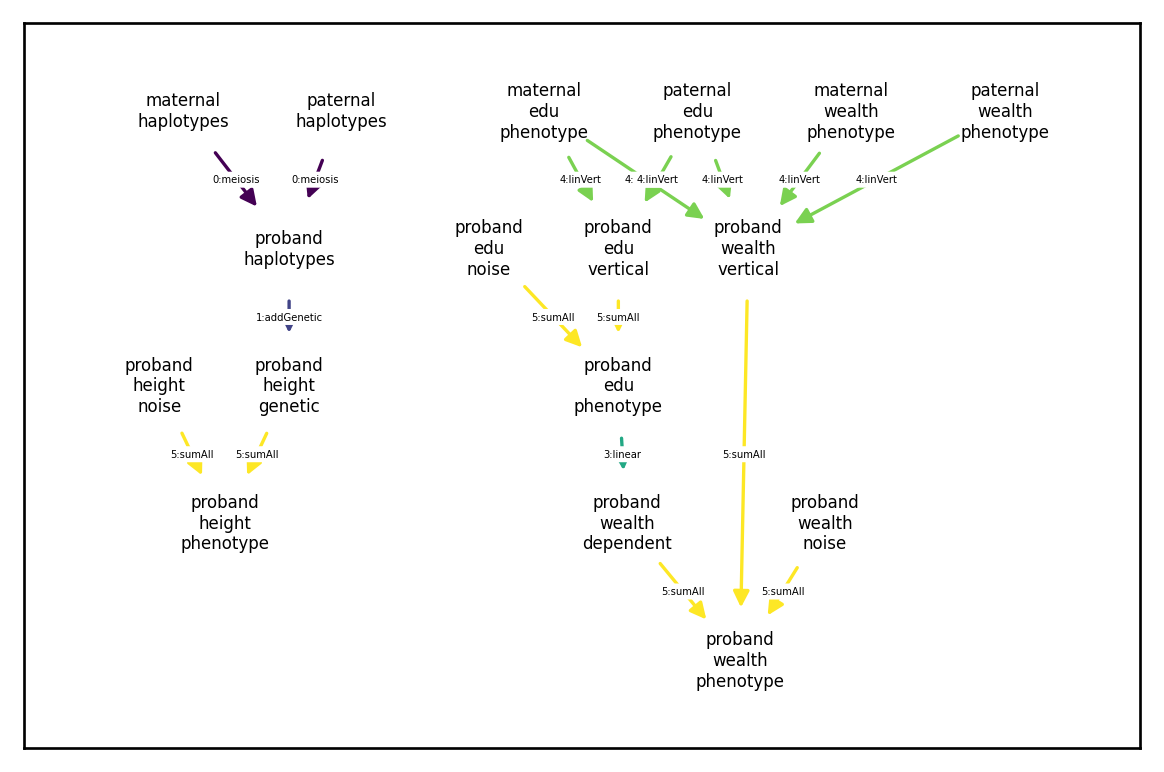

In [66]:
arch.draw_dependency_graph(font_size=5, node_size=1000)


Specifically, the `edu phenotype` node generated by the sum transformation (yellow arrows) but has a causal effect (teal arrow) on the `wealth dependent` component, which is again used by the sum transformation to construct the `wealth phenotype` component.

## Avoiding circular dependences

There are multiple ways to avoid this sort of circular dependency. The first would be to have the `wealth dependent` component depend directly on `edu noise` and `edu vertical`:



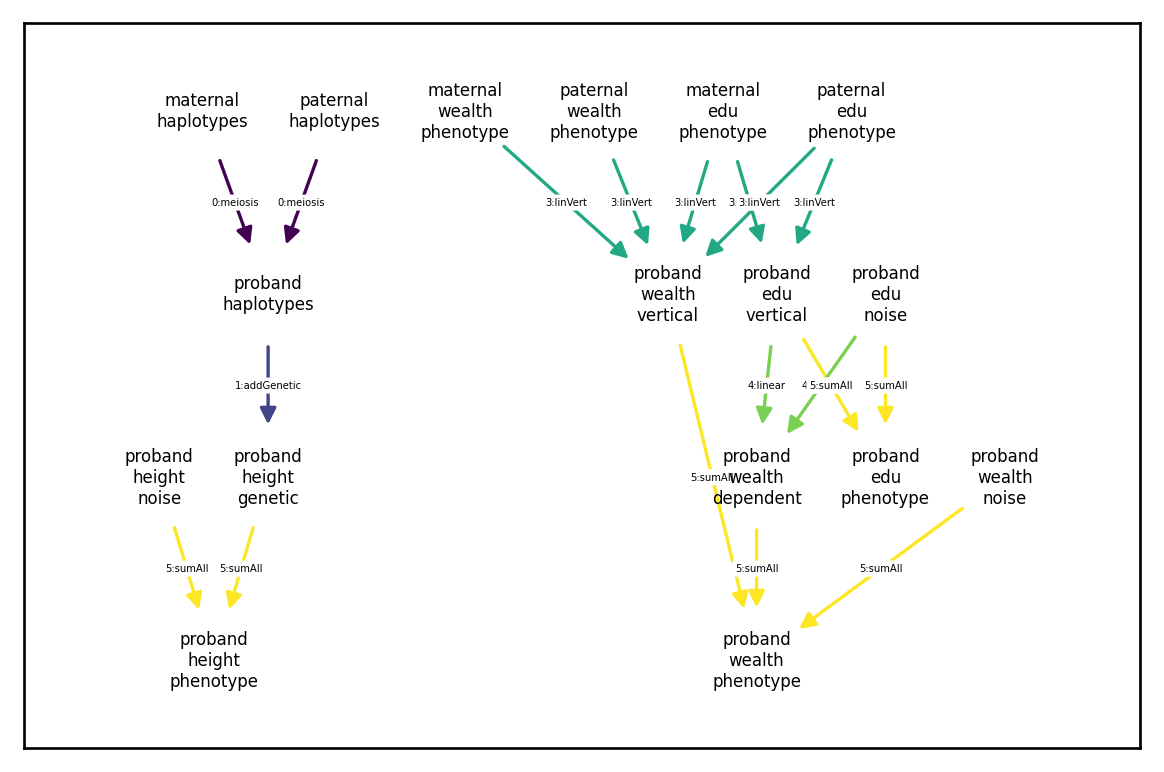

In [67]:
input_ind = xft.index.ComponentIndex.from_product(['edu'], ['noise', 'vertical'])
output_ind = xft.index.ComponentIndex(['wealth'], ['dependent'])
coefficient_matrix = np.array([[np.sqrt(1/6),np.sqrt(1/6)]])

causal_comp_redux = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
input_cindex=xft.index.ComponentIndex(['height','height','edu', 'edu', 'wealth', 'wealth','wealth'], 
                                      ['genetic','noise','noise', 'vertical', 'noise', 'vertical','dependent'])

strans = xft.arch.SumAllTransformation(input_cindex)

arch_redux1 = xft.arch.Architecture([genetic_comp,
                                     noise_comp,
                                     vt_comp,
                                     causal_comp_redux,
                                     strans])
arch_redux1.draw_dependency_graph(font_size=5, node_size=1000)

We can tell that there are no circular dependencies because all directed paths through the network travel through each color at most once. An alternative method for avoid circular dependences would be to keep the dependence between `wealth dependent` and `edu phenotype` but compute the sums in two steps:

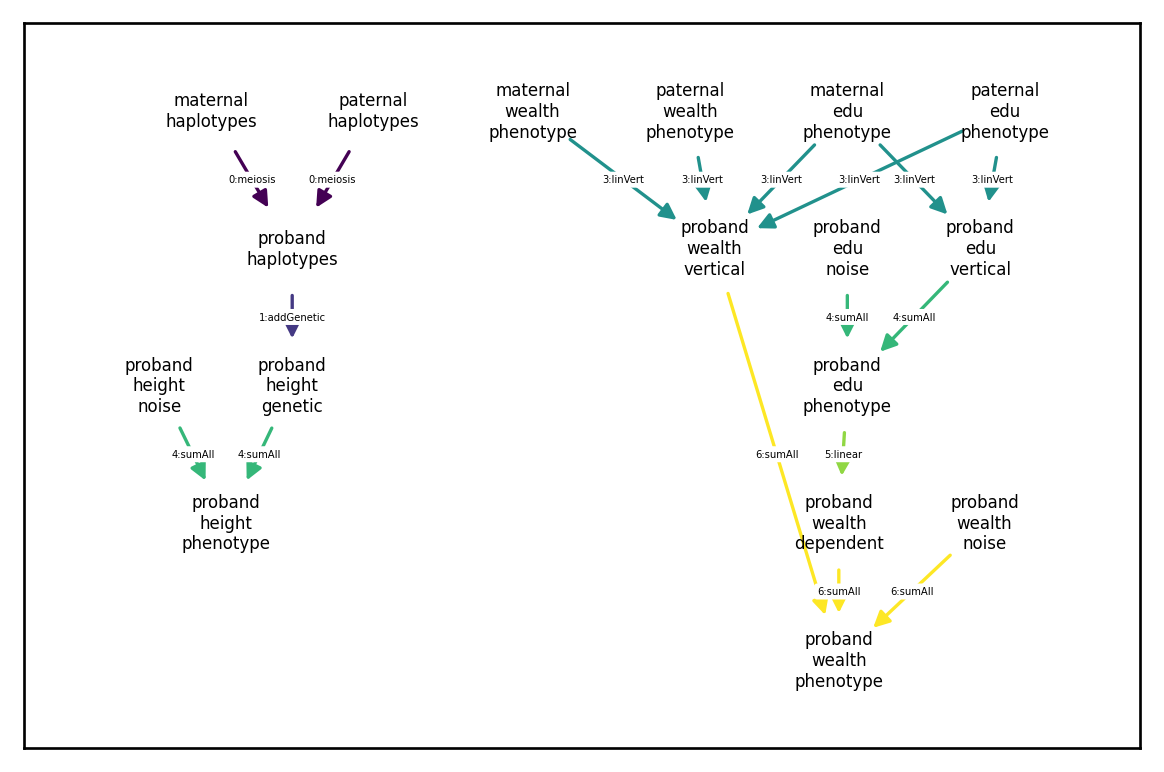

In [68]:
input_cindex=xft.index.ComponentIndex(['height','height','edu', 'edu'], 
                                      ['genetic','noise','noise', 'vertical'])

strans_redux1 = xft.arch.SumAllTransformation(input_cindex)
                                                                   
input_cindex=xft.index.ComponentIndex(['wealth', 'wealth','wealth'], 
                                      ['noise', 'vertical','dependent'])

strans_redux2 = xft.arch.SumAllTransformation(input_cindex)
                                                                                                  
                                                                   
arch_redux2 = xft.arch.Architecture([genetic_comp,
                                     noise_comp,
                                     vt_comp,
                                     strans_redux1,
                                     causal_comp,
                                     strans_redux2])
arch_redux2.draw_dependency_graph(font_size=5, node_size=800)

Both of these reformulations are equivalent and will produce expected results:

In [69]:
sim_redux1 = xft.sim.Simulation(architecture=arch_redux1,
                   founder_haplotypes=founder_haplotypes,
                   recombination_map=rmap,
                   mating_regime=mating,
                   statistics=[xft.stats.SampleStatistics(),
                               xft.stats.MatingStatistics(),
                               xft.stats.HasemanElstonEstimator(randomized=True)])
sim_redux1.run(1)
sim_redux1.phenotypes.xft.as_pd()

phenotype_name       height                 edu    wealth       edu            \
component_name      genetic     noise     noise     noise phenotype             
vorigin_relative    proband   proband   proband   proband    mother    father   
iid    fid    sex                                                               
0_0    0_0    0    0.584003  0.672100  0.976179  0.382930 -0.157761 -0.180020   
0_1    0_1    1   -0.218097  0.197399 -0.311239 -0.964232  0.165647  0.522241   
0_2    0_2    0   -0.229252 -1.928559 -1.084152  0.214785 -1.547989 -1.699411   
0_3    0_3    1   -0.059315  0.250060  1.316109 -0.398935 -1.198616 -0.751229   
0_4    0_4    0    0.290709 -0.847944  0.774900  0.516141  0.607842  0.621349   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1   -1.007374  0.439812 -0.612737 -0.561097 -1.009259 -0.842660   
0_3996 0_3996 0    0.092540 -0.232532 -0.100014  0.379286  1.118002 -0.548150   
0_3997 0_3997 1   -0.332271  0.313549  0.124159 -0.062290 -0.246119 -0.919103   
0_3998 0_3998 0   -1.388650 -0.050095  0.535196 -0.038207  0.823217 -0.667772   
0_3999 0_3999 1    1.567026  0.234648 -0.267894  0.947193  0.859699  0.687864   

phenotype_name       wealth                 edu    wealth              height  \
component_name    phenotype            vertical  vertical dependent phenotype   
vorigin_relative     mother    father   proband   proband   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0   -1.189684  0.351861 -0.166751 -0.466701  0.614900  1.256103   
0_1    0_1    1    0.299093 -0.914562  0.427751  0.049213 -0.007828 -0.020697   
0_2    0_2    0   -2.117230  0.011480 -1.850102 -2.178403 -1.705843 -2.157811   
0_3    0_3    1   -1.077270 -1.338046 -1.097612 -1.769694  0.390392  0.190746   
0_4    0_4    0   -0.122428  0.855083  0.739703  0.819814  0.926385 -0.557235   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1   -1.362419 -2.106461 -1.041902 -2.162044 -0.962237 -0.567562   
0_3996 0_3996 0    1.019050 -0.689448  0.352773  0.384913  0.105680 -0.139991   
0_3997 0_3997 1   -0.353352  0.027159 -0.647500 -0.594822 -0.236568 -0.018722   
0_3998 0_3998 0   -1.231679  0.596314  0.113661 -0.185753  0.440180 -1.438745   
0_3999 0_3999 1   -0.205601 -0.728145  0.923235  0.267851  0.272212  1.801675   

phenotype_name          edu    wealth  
component_name    phenotype phenotype  
vorigin_relative    proband   proband  
iid    fid    sex                      
0_0    0_0    0    0.809428  0.531129  
0_1    0_1    1    0.116512 -0.922847  
0_2    0_2    0   -2.934254 -3.669461  
0_3    0_3    1    0.218497 -1.778238  
0_4    0_4    0    1.514603  2.262340  
...                     ...       ...  
0_3995 0_3995 1   -1.654639 -3.685378  
0_3996 0_3996 0    0.252759  0.869880  
0_3997 0_3997 1   -0.523341 -0.893679  
0_3998 0_3998 0    0.648856  0.216219  
0_3999 0_3999 1    0.655340  1.487256  

[4000 rows x 14 columns]

In [70]:
sim_redux2 = xft.sim.Simulation(architecture=arch_redux2,
                   founder_haplotypes=founder_haplotypes,
                   recombination_map=rmap,
                   mating_regime=mating,
                   statistics=[xft.stats.SampleStatistics(),
                               xft.stats.MatingStatistics(),
                               xft.stats.HasemanElstonEstimator(randomized=True)])
sim_redux2.run(1)
sim_redux2.phenotypes.xft.as_pd()

phenotype_name       height                 edu    wealth       edu            \
component_name      genetic     noise     noise     noise phenotype             
vorigin_relative    proband   proband   proband   proband    mother    father   
iid    fid    sex                                                               
0_0    0_0    0    0.584003  0.937483  1.119908 -0.224454  0.301418 -1.294262   
0_1    0_1    1   -0.218097 -0.124517  0.437604  0.556914  0.308113  2.493515   
0_2    0_2    0   -0.229252  0.966631  0.992141 -0.223374 -0.091098  0.466370   
0_3    0_3    1   -0.059315 -0.995794 -1.097226  0.276910 -0.851076 -1.045198   
0_4    0_4    0    0.290709 -0.036948  0.078698 -0.203392  1.140805 -1.899080   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1   -1.007374  1.208256  0.303435  1.170934 -1.644025  1.450823   
0_3996 0_3996 0    0.092540  0.703620 -0.111665  0.155786  0.676138  1.653388   
0_3997 0_3997 1   -0.332271  0.754979 -0.167393 -0.194926 -1.451782  0.636239   
0_3998 0_3998 0   -1.388650 -0.009382 -0.480940  0.714000 -1.182875 -2.300085   
0_3999 0_3999 1    1.567026 -0.076613 -0.694219 -0.192502  1.882590 -1.503772   

phenotype_name       wealth                 edu    wealth    height       edu  \
component_name    phenotype            vertical  vertical phenotype phenotype   
vorigin_relative     mother    father   proband   proband   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0   -0.490020 -0.484853 -0.574505 -0.810815  1.521486  0.545403   
0_1    0_1    1   -0.691657 -1.574197  1.594472  0.199263 -0.342614  2.032076   
0_2    0_2    0    1.524648  1.446673  0.208555  1.357091  0.737379  1.200696   
0_3    0_3    1    0.851566  0.031159 -1.087935 -0.410178 -1.055109 -2.185162   
0_4    0_4    0   -0.243960 -0.393371 -0.442598 -0.578751  0.253760 -0.363900   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1   -0.427458  0.556748 -0.112370 -0.037259  0.200882  0.191066   
0_3996 0_3996 0    0.504562 -2.409073  1.323655  0.165434  0.796161  1.211989   
0_3997 0_3997 1   -1.663091 -0.044210 -0.468611 -1.043324  0.422707 -0.636004   
0_3998 0_3998 0    0.312996 -1.019039 -1.994056 -1.698136 -1.398032 -2.474996   
0_3999 0_3999 1    1.899746 -1.808135  0.205463  0.194935  1.490413 -0.488755   

phenotype_name       wealth            
component_name    dependent phenotype  
vorigin_relative    proband   proband  
iid    fid    sex                      
0_0    0_0    0    0.313878 -0.721390  
0_1    0_1    1    1.168725  1.924902  
0_2    0_2    0    0.690676  1.824393  
0_3    0_3    1   -1.256213 -1.389482  
0_4    0_4    0   -0.208976 -0.991119  
...                     ...       ...  
0_3995 0_3995 1    0.110132  1.243808  
0_3996 0_3996 0    0.697170  1.018390  
0_3997 0_3997 1   -0.365438 -1.603689  
0_3998 0_3998 0   -1.422870 -2.407006  
0_3999 0_3999 1   -0.280769 -0.278336  

[4000 rows x 14 columns]

:::{tip}

We can give each a custom name for displaying on the dependency graph using the `component_name` argument.

:::

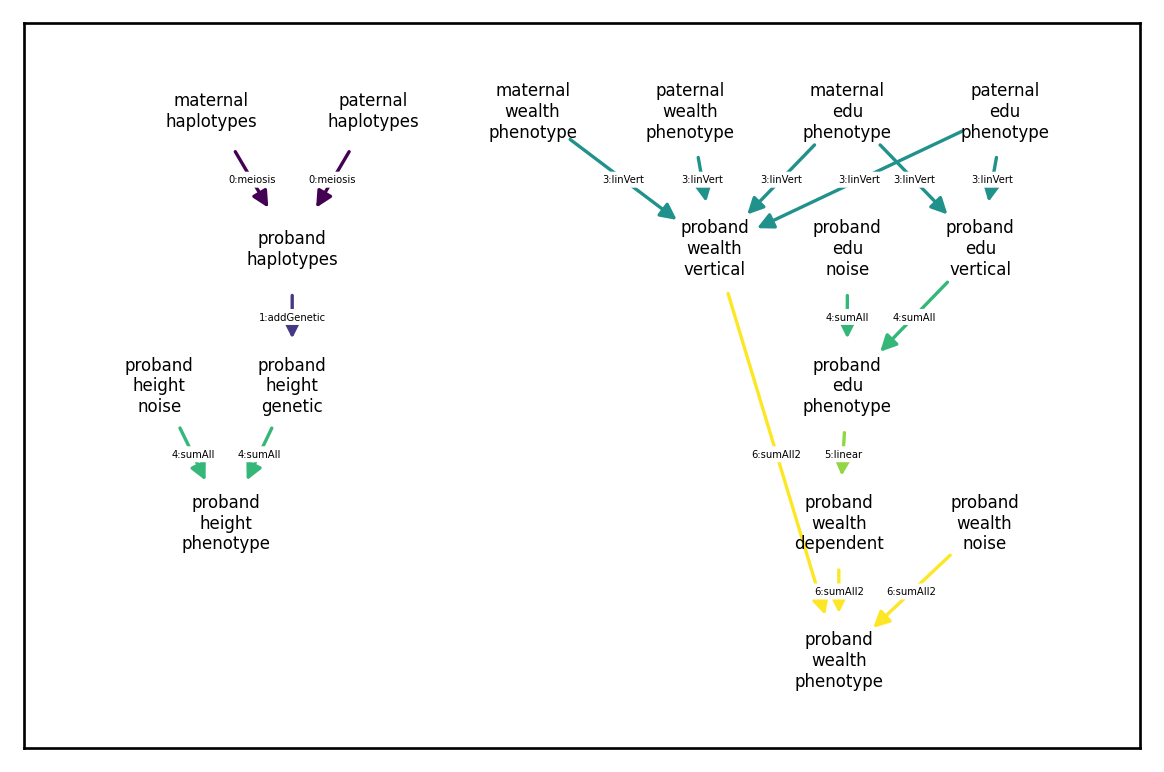

In [71]:
input_cindex=xft.index.ComponentIndex(['wealth', 'wealth','wealth'], 
                                      ['noise', 'vertical','dependent'])

strans_redux3 = xft.arch.SumAllTransformation(input_cindex,
                                              component_name='sumAll2')
                                                                                                                                                                
                                                                   
arch_redux3 = xft.arch.Architecture([genetic_comp,
                                     noise_comp,
                                     vt_comp,
                                     strans_redux1,
                                     causal_comp,
                                     strans_redux3])
arch_redux3.draw_dependency_graph(font_size=5, node_size=800)